In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from mpl_toolkits import mplot3d
from pauli import *
from qm_tools import sort_eigensystem, plot_spectrum
from tqdm.notebook import tqdm

In [80]:
t = 4
mu = 2 * t
az = 0
eta = 0.05
hx = 0.0
hy = 0.0
hz = 0.0
Delta = 1
delta = 0.005  # Small imaginary part for numerical stability


def H_s(kx, ky, t, mu, az, eta, hx, hy, hz, Delta):
    H = np.zeros((4, 4), dtype=complex)
    H += np.kron(tzs0, 2 * t * (2 - np.cos(kx) - np.cos(ky)) - mu)
    H += np.kron(tzsy, +az * kx)
    H += np.kron(tzsx, -az * ky)
    H += np.kron(t0sz, eta * 2 * t * (np.cos(kx) - np.cos(ky)))
    H += np.kron(t0sx, hx)
    H += np.kron(t0sy, hy)
    H += np.kron(t0sz, hz)
    H += np.kron(txs0, Delta)
    return H


def G(omega):
    G_inv = np.zeros((4, 4), dtype=complex)
    k_ax = np.linspace(-np.pi, np.pi, 401)
    dk = k_ax[1] - k_ax[0]
    for kx in k_ax:
        for ky in k_ax:
            H = H_s(kx, ky, t, mu, az, eta, hx, hy, hz, Delta)
            G_inv += np.linalg.inv((omega + 1j * delta) * np.eye(4) - H)
    return G_inv * (dk**2) / (4 * np.pi**2)

In [81]:
# Frequency axis
omega_ax = np.linspace(-2, 2, 201)

G_values = []
for omega in tqdm(omega_ax):
    G_omega = G(omega)
    G_values.append(G_omega)

100%|██████████| 201/201 [40:54<00:00, 12.21s/it]  


In [82]:
DOS = []
DOS_u = []
DOS_d = []

for i, omega in tqdm(enumerate(omega_ax), total=len(omega_ax)):
    DOS.append(np.trace(G_values[i] @ t0s0).imag)
    DOS_u.append(np.trace(G_values[i] @ (t0s0 + t0sz)).imag)
    DOS_d.append(np.trace(G_values[i] @ (t0s0 - t0sz)).imag)

# Convert DOS to a numpy array for easier handling
DOS = np.array(DOS)
DOS_u = np.array(DOS_u)
DOS_d = np.array(DOS_d)

100%|██████████| 201/201 [00:00<00:00, 2767.65it/s]


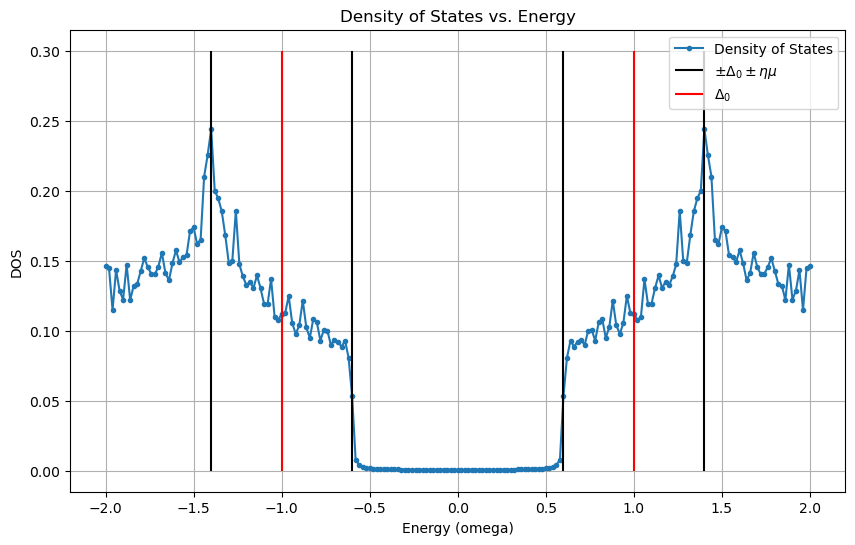

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(omega_ax, -1 / np.pi * DOS, ".-", label="Density of States")
plt.xlabel("Energy (omega)")
plt.ylabel("DOS")
plt.title("Density of States vs. Energy")
plt.legend()
plt.grid(True)

ax.vlines(
    [-Delta - eta * mu, -Delta + eta * mu, +Delta - eta * mu, +Delta + eta * mu],
    0,
    0.3,
    colors="k",
    label=r"$\pm\Delta_0\pm\eta\mu$",
)
ax.vlines([-Delta, Delta], 0.0, 0.3, colors="r", label=r"$\Delta_0$")
ax.legend()